## Imports

In [1]:
import os
import sys
import shutil

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex = True)

plt.rcParams.update(  # try to match font sizes of document
  {'axes.labelsize': 20,
   'axes.titlesize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   'font.family': 'serif',
   'font.serif': ['palatino'],
   'savefig.dpi': 300
   })

%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from GWNRTools.Utils.SupportFunctions import make_padded_frequency_series
from pycbc import pnutils

Populating the interactive namespace from numpy and matplotlib


/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read


In [2]:
sys.path.append('/home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/')

In [3]:
os.chdir('/home/prayush.kumar/projects/template_banks/faithfulness_vs_SEOBNRv4')

In [4]:
!ls

bank			 faithsim.dag.lib.out	 log
collect_results.sub	 faithsim.dag.metrics	 match
dag.out			 faithsim.dag.nodes.log  plots
faithsim.dag		 faithsim-flatIMRC.sub	 result-flatIMRC.dat
faithsim.dag.condor.sub  faithsim.ini		 scripts
faithsim.dag.dagman.log  faithsim_plots.sub	 submit.sh
faithsim.dag.dagman.out  faithsim.sh
faithsim.dag.lib.err	 inj.xml


In [5]:
!rm -fr *

In [6]:
!rm -rf bank log match plots scripts *.sub faithsim.dag* faithsim.sh inj*xml dag.out result*.dat submit.sh

In [7]:
!ls

## Create workflow

In [8]:
ini_filename = "faithsim.ini"

In [9]:
with open(ini_filename, "w") as fp:
    fp.write("""
[inspinj]
num-new-points = 5000
component-mass-min = 5.0
component-mass-max = 50.0
total-mass-max = 100.0
spin-component-min = 0
spin-component-max = 0
spin-mag-min = 0
spin-mag-max = 0
eccentricity-min = 0
eccentricity-max = 0
coa-phase-min = 0
coa-phase-max = 0
inclination-min = 0
inclination-max = 0
long-asc-nodes-min = 0
long-asc-nodes-max = 0
mean-per-ano-min = 0
mean-per-ano-max = 0
mchirp-window = 0
eccentricity-window = 0
output-prefix = inj
verbose =


[executables]
inspinj = /home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/gwnrtools_sample_parameter_space
faithsim = /home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/gwnrtools_faithsim

[workflow]
accounting-group = ligo.dev.o3.cbc.explore.test
templates-per-job = 100
log-path = /usr1/prayush.kumar/

[faithsim-flatIMRC]
psd-model = aLIGOZeroDetHighPower
waveform1-approximant = SEOBNRv4_ROM
waveform1-start-frequency=24
waveform2-approximant = ENIGMA
waveform2-start-frequency=24
filter-low-frequency=25
filter-sample-rate=8192 
filter-waveform-length=64
""")

In [10]:
!/home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/gwnrtools_create_faithsim_workflow \
 --config=faithsim.ini

2020-01-14 23:15:45,600 Making workspace directories
2020-01-14 23:15:45,678 Copying scripts
2020-01-14 23:15:45,685 Creating injection file
Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read
2020-01-14 23:15:49,846 | INFO : mchirp-window = 0.000000
2020-01-14 23:15:49,846 | INFO : eccentricity-window = 0.000000
2020-01-14 23:15:49,847 | INFO : Storing the new sample points in inj.xml
2020-01-14 23:15:49,859 | INFO : 0 points chosen
2020-01-14 23:15:49,878 | INFO : 100 points chosen
2020-01-14 23:15:49,905 | INFO : 200 points chosen
2020-01-14 23:15:49,941 | INFO : 300 points chosen
2020-01-14 23:15:49,988 | INFO : 400 points chosen
2020-01-14 23:15:50,045 | INFO : 500 points chosen
2020-01-14 23:15:50,108 | INFO : 600 points chosen
2020-01-14 23:15:50,178 | INFO : 700 points chosen
2020-01-14 23:15:50,261 | INFO : 800 points chosen
2020-01-14 23:15:50,359 | INFO : 900 points chosen
2020-01-14 23:15:50,45

### Verify test injections

In [11]:
def param_from_table(param, table):
    return np.array([
        getattr(p, param) for p in table
    ])

In [12]:
inj_filename = 'inj.xml'
indoc = ligolw_utils.load_filename(inj_filename, contenthandler=table.use_in(ligolw.LIGOLWContentHandler))
inj_table = lsctables.SimInspiralTable.get_table(indoc)
print("Total {} test-points".format(len(inj_table)))

Total 5000 test-points


In [13]:
m1 = np.array([inj.mass1 for inj in inj_table])
m2 = np.array([inj.mass2 for inj in inj_table])

/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


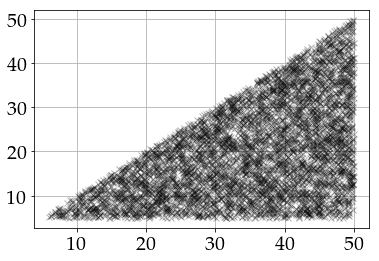

In [14]:
plot(m1, m2, 'kx', alpha=0.3)
grid()

## Submit and monitor job

In [15]:
!ls

bank		     faithsim-flatIMRC.sub  faithsim.sh  match	  submit.sh
collect_results.sub  faithsim.ini	    inj.xml	 plots
faithsim.dag	     faithsim_plots.sub     log		 scripts


In [16]:
!cat -n faithsim-flatIMRC.sub

     1	universe = vanilla
     2	executable = scripts/pycbc_faithsim
     3	arguments = " --psd-model aLIGOZeroDetHighPower --waveform2-start-frequency 24 --filter-low-frequency 25 --param-file $(macroparamfile) --filter-waveform-length 64 --waveform1-start-frequency 24 --filter-sample-rate 8192 --match-file $(macromatchfile) --waveform1-approximant SEOBNRv4_ROM --waveform2-approximant ENIGMA "
     4	+Allow_OGrid = True
     5	accounting_group = ligo.dev.o3.cbc.explore.test
     6	getenv = True
     7	log = /usr1/prayush.kumar/tmpRuMS8p
     8	error = log/pycbc_faithsim-$(cluster)-$(process).err
     9	output = log/pycbc_faithsim-$(cluster)-$(process).out
    10	notification = never
    11	queue 1


In [17]:
!condor_submit_dag faithsim.dag >> dag.out
!cat dag.out

Submitting job(s).
1 job(s) submitted to cluster 36302407.

-----------------------------------------------------------------------
File for submitting this DAG to HTCondor           : faithsim.dag.condor.sub
Log of DAGMan debugging messages                 : faithsim.dag.dagman.out
Log of HTCondor library output                     : faithsim.dag.lib.out
Log of HTCondor library error messages             : faithsim.dag.lib.err
Log of the life of condor_dagman itself          : faithsim.dag.dagman.log

-----------------------------------------------------------------------


In [20]:
!tail faithsim.dag.dagman.out 

01/14/20 23:16:20 Number of idle job procs: 47
01/14/20 23:16:20 Reassigning the id of job c827f7bac1e11820fdf34edac173ff35 from (36302455.0.0) to (36302455.0.0)
01/14/20 23:16:20 Event: ULOG_SUBMIT for HTCondor Node c827f7bac1e11820fdf34edac173ff35 (36302455.0.0) {01/14/20 23:16:15}
01/14/20 23:16:20 Number of idle job procs: 48
01/14/20 23:16:20 Reassigning the id of job e528b1bf4e6d2f9c65f870e68ea36990 from (36302456.0.0) to (36302456.0.0)
01/14/20 23:16:20 Event: ULOG_SUBMIT for HTCondor Node e528b1bf4e6d2f9c65f870e68ea36990 (36302456.0.0) {01/14/20 23:16:15}
01/14/20 23:16:20 Number of idle job procs: 49
01/14/20 23:16:20 Reassigning the id of job cb1143dc91233aa485cc1a4cc44c5e56 from (36302457.0.0) to (36302457.0.0)
01/14/20 23:16:20 Event: ULOG_SUBMIT for HTCondor Node cb1143dc91233aa485cc1a4cc44c5e56 (36302457.0.0) {01/14/20 23:16:15}
01/14/20 23:16:20 Number of idle job procs: 50


## Explore results

In [21]:
import glob
results_filename = glob.glob('result-*.dat')[0] #'result-flatIMRC.dat'

In [22]:
bfields = ('match', 'overlap', 'time_offset', 'sigma1', 'sigma2', 'mass1',
           'mass2', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y',
           'spin2z', 'inclination', 'latitude', 'longitude',
           'polarization', 'coa_phase')
dtypeo={'names': bfields,
        'formats': ('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8',
                    'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8')}

In [23]:
results = np.loadtxt(results_filename, dtype = dtypeo)

In [24]:
results.dtype.names

('match',
 'overlap',
 'time_offset',
 'sigma1',
 'sigma2',
 'mass1',
 'mass2',
 'spin1x',
 'spin1y',
 'spin1z',
 'spin2x',
 'spin2y',
 'spin2z',
 'inclination',
 'latitude',
 'longitude',
 'polarization',
 'coa_phase')

In [25]:
masked_results = results[np.isfinite(results['match'])]

In [26]:
print(len(masked_results['match']))
print(masked_results['match'])

5000
[0.98867 0.99533 0.98846 ... 0.99348 0.99571 0.99254]


In [27]:
plot_dir = '/home/prayush.kumar/src/EccentricIMRTemplateBank/Paper/plots'

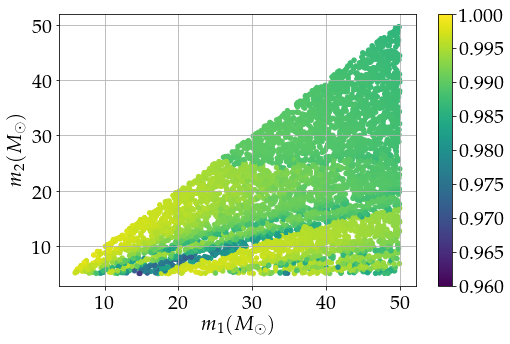

In [28]:
plt.figure(figsize = (8, 5))
plt.scatter(masked_results['mass1'],
            masked_results['mass2'],
            s = 20,
            c = masked_results['match'],
            vmax =  1, vmin = 0.96)
plt.xlabel('$m_1 (M_\odot)$', fontsize = 20)
plt.ylabel('$m_2 (M_\odot)$', fontsize = 20)
plt.grid()
plt.colorbar()#(label='Overlap')
plt.savefig(os.path.join(plot_dir, 'SEOBNRv4_ENIGMA_no_incl_no_ecc_match_over_mass1_mass2_scatter.pdf'))

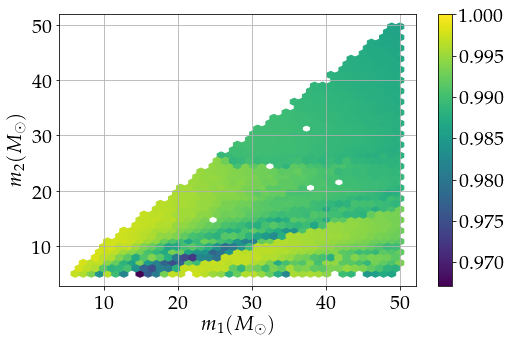

In [32]:
plt.figure(figsize = (8, 5))
plt.hexbin(masked_results['mass1'],
            masked_results['mass2'],
            C = masked_results['match'], gridsize = 40,
            vmax =  1)
plt.xlabel('$m_1 (M_\odot)$', fontsize = 20)
plt.ylabel('$m_2 (M_\odot)$', fontsize = 20)
plt.grid()
plt.colorbar()#(label='Overlap')
plt.savefig(os.path.join(plot_dir, 'SEOBNRv4_ENIGMA_no_incl_no_ecc_match_over_mass1_mass2_hex.pdf'))

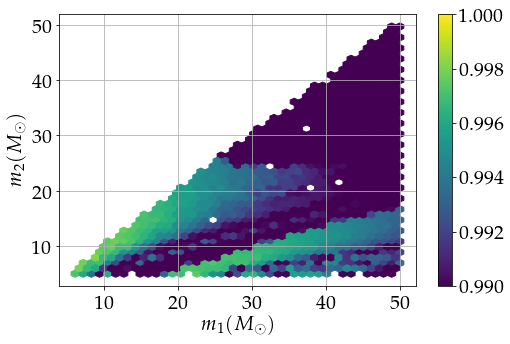

In [33]:
plt.figure(figsize = (8, 5))
plt.hexbin(masked_results['mass1'],
            masked_results['mass2'],
            C = masked_results['match'], gridsize = 40,
            vmax =  1,
            vmin = 0.99)
plt.xlabel('$m_1 (M_\odot)$', fontsize = 20)
plt.ylabel('$m_2 (M_\odot)$', fontsize = 20)
plt.grid()
plt.colorbar()#(label='Overlap')
#plt.savefig(os.path.join(plot_dir, 'SEOBNRv4_ENIGMA_no_incl_no_ecc_match_over_mass1_mass2_hex.pdf'))